In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [2]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tools.eval_measures import meanabs, rmse
from statsmodels.tsa.stattools import adfuller,kpss

In [3]:
def invert_difference(data,residual):
    ind = data.index.get_loc(residual.index[0])
    if ind > 0:
        length = len(residual)
        vals = np.array(data.iloc[ind-1:ind-1+length]) + np.array(residual)
    else:
        residual = residual[1:]
        length = len(residual)
        vals = np.array(data.iloc[ind:ind+length]) + np.array(residual)
    result = pd.Series(vals,index=residual.index)
    return result

In [5]:
path = 'data/SLV_working.pkl'
with open(path, 'rb') as f:
    slv_clean=pickle.load(f)

In [6]:
weekly=slv_clean['Close'].resample('W').last()

In [8]:
data = weekly.diff().dropna()
train_ratio = 0.8
split = round(train_ratio * len(data))
train, test = data.iloc[0:split], data.iloc[split:]
data = weekly
slv_train, slv_test = data.iloc[0:split], data.iloc[split:]

**To model, we split the data into training and test sets. We use the first 80% of the data as the training set.**

In [10]:
metrics = []
for d in range(3):
    for p in range(7):
        for q in range(6):
            try:
                model = ARIMA(train,order=(p,d,q),trend='n')
                result = model.fit()
                metrics.append((p,d,q,result.aic,result.bic))
            except:
                pass
metr_diff = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_diff.sort_values('AIC').head()

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,p,d,q,AIC,BIC
32,5,0,2,1842.984056,1878.738059
38,6,0,2,1844.683292,1884.906545
39,6,0,3,1846.907703,1891.600206
82,6,1,4,1853.807829,1902.952515
83,6,1,5,1856.087509,1909.699893


In [11]:
metr_diff.sort_values('BIC').head()

,p,d,q,AIC,BIC
32,5,0,2,1842.984056,1878.738059
0,0,0,0,1877.127598,1881.596848
3,0,0,3,1863.960886,1881.837888
18,3,0,0,1865.960770,1883.837772
38,6,0,2,1844.683292,1884.906545


In [13]:
model = ARIMA(train,order=(5,0,2),trend='n')
arma502 = model.fit()
print(arma502.summary())

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  645
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -913.492
Date:                Mon, 27 Dec 2021   AIC                           1842.984
Time:                        16:45:10   BIC                           1878.738
Sample:                    05-07-2006   HQIC                          1856.857
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2647      0.049      5.398      0.000       0.169       0.361
ar.L2         -0.8804      0.040    -21.772      0.000      -0.960      -0.801
ar.L3         -0.1103      0.048     -2.288      0.0

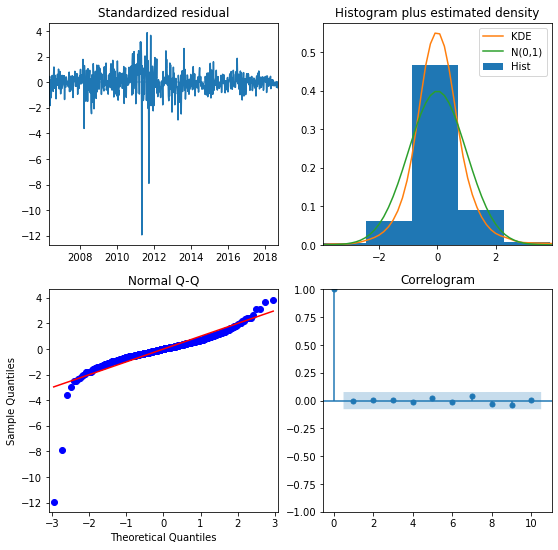

In [14]:
arma502.plot_diagnostics(figsize=(9,9))
plt.show()

In [15]:
metrics = []
d = 0
D = 0
for p in range(6):
    for q in range(3):
        for s in range(4):
            for P in range(6):
                for Q in range(3):
                    try:
                        model = ARIMA(train,order=(p,d,q),seasonal_order=(P,D,Q,s),trend='n')
                        result = model.fit()
                        metrics.append((p,d,q,P,D,Q,s,result.aic,result.bic))
                    except:
                        pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','P','D','Q','s','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,p,d,q,P,D,Q,s,AIC,BIC
316,5,0,2,0,0,0,3,1842.984056,1878.738059
315,5,0,2,0,0,0,2,1842.984056,1878.738059
314,5,0,2,0,0,0,0,1842.984056,1878.738059
318,5,0,2,0,0,2,3,1844.245103,1888.937606
298,4,0,2,0,0,1,3,1844.979601,1880.733603


In [5]:
prediction502 = 

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  644
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -912.576
Date:                Mon, 20 Dec 2021   AIC                           1841.152
Time:                        09:58:41   BIC                           1876.893
Sample:                    05-14-2006   HQIC                          1855.021
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2647      0.049      5.390      0.000       0.168       0.361
ar.L2         -0.8804      0.040    -21.741      0.000      -0.960      -0.801
ar.L3         -0.1103      0.048     -2.285      0.022      -0.205      -0.016
ar.L4          0.0771      0.030      2.555      0.011       0.018       0.136
ar.L5         -0.2311      0.035     -6.645      0.000      -0.299      -0.163
ma.L1         -0.2117      0.038     -5.630      0.000      -0.285      -0.138
ma.L2          0.9109      0.035     25.854      0.000       0.842       0.980
sigma2         0.9951      0.025     39.244      0.000       0.945       1.045
===================================================================================
Ljung-Box (Q):                       60.08   Jarque-Bera (JB):             37668.62
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -3.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
residual = arma502.resid
metrics = []
for p in range(6):
    for q in range(6):
        try:
            gmodel = arch_model(residual,p=p,q=q,mean='Constant',vol='GARCH',dist='skewt')
            gresult = gmodel.fit(disp='off')
            metrics.append((p,q,'yes',gresult.aic,gresult.bic))
        except:
            pass
for p in range(6):
    for q in range(6):
        try:
            gmodel = arch_model(residual,p=p,q=q,mean='Constant',vol='GARCH',dist='t')
            gresult = gmodel.fit(disp='off')
            metrics.append((p,q,'no',gresult.aic,gresult.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','q','skew','AIC','BIC'])
metr_resid.sort_values('AIC').head(6)

,p,q,skew,AIC,BIC
44,3,2,no,1454.368047,1490.122050
43,3,1,no,1455.130842,1486.415595
31,1,1,no,1455.171196,1477.517448
50,4,2,no,1455.470298,1495.693551
38,2,2,no,1455.994472,1487.279224
14,3,2,yes,1456.147771,1496.371024


In [17]:
gmodel = arch_model(residual,p=3,q=2,mean='Constant',vol='GARCH',dist='t')
vol_arma502 = gmodel.fit(disp='off')
vol_arma502.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -719.184
Distribution:      Standardized Student's t   AIC:                           1454.37
Method:                  Maximum Likelihood   BIC:                           1490.12
                                              No. Observations:                  645
Date:                      Mon, Dec 27 2021   Df Residuals:                      644
Time:                              16:54:58   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0117  2.664e-02     -0.439      0.660 [-6.391e-02,4.050e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0122  9.841e-03      1.238      0.216 [-7.105e-03,3.147e-02]
alpha[1]       0.0455  4.199e-02      1.083      0.279   [-3.682e-02,  0.128]
alpha[2]       0.0162  7.975e-02      0.203      0.839      [ -0.140,  0.173]
alpha[3]       0.1340  6.442e-02      2.081  3.746e-02    [7.777e-03,  0.260]
beta[1]        0.0000  5.142e-02      0.000      1.000      [ -0.101,  0.101]
beta[2]        0.7981  5.114e-02     15.606  6.674e-55      [  0.698,  0.898]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.4119      1.688      3.799  1.453e-04 [  3.104,  9.720]
========================================================================

Covariance estimator: robust
"""

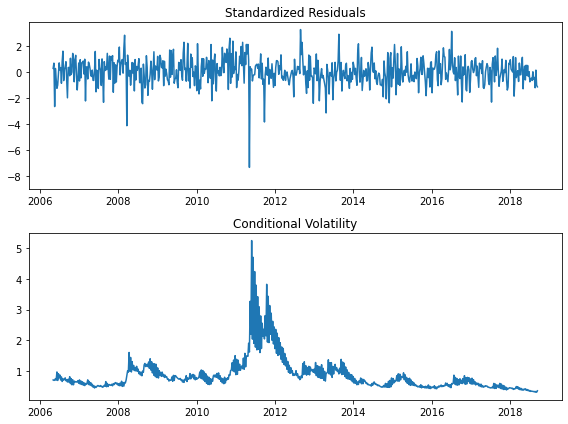

In [18]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(vol_arma502.std_resid)
ax1.set_ylim(-9,3.8)
ax1.set_title('Standardized Residuals')
ax2.plot(vol_arma502.conditional_volatility)
ax2.set_title('Conditional Volatility')
fig.tight_layout()

In [20]:
vol_forecast=vol_arma502.forecast(horizon=1,reindex=False).mean

In [21]:
vol_forecast

,h.1
Date,
2018-09-09,-0.011705


In [22]:
train.tail()

Date
2018-08-12   -0.09
2018-08-19   -0.49
2018-08-26    0.00
2018-09-02   -0.27
2018-09-09   -0.33
Freq: W-SUN, Name: Close, dtype: float64

In [47]:
base_pred_mean = test
base_pred_mean[:] = 0.0
base_pred = invert_difference(slv_test,base_pred_mean)
mae_base = meanabs(slv_test[1:],base_pred)
rmse_base = rmse(slv_test[1:],base_pred)
print(f'Base MAE = {mae_base:.3f}, Base RMSE = {rmse_base:.3f}')

Base MAE = 0.518, Base RMSE = 0.822


<AxesSubplot:xlabel='Date'>

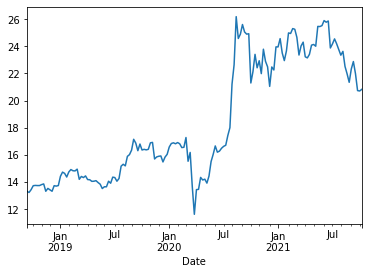

In [45]:
base_pred.plot()

In [173]:
slv_train['2017-09-10':'2018-09-09'].head()

Date
2017-09-10    17.020000
2017-09-17    16.620001
2017-09-24    16.049999
2017-10-01    15.740000
2017-10-08    15.850000
Freq: W-SUN, Name: Close, dtype: float64

In [209]:
len(slv_train)

564

In [213]:
slv_train.tail()

,Day,Open,Low,High,Close,Volume
Date,,,,,,
2008-07-18,560,18.114000,17.858000,18.270000,17.968000,6924000
2008-07-21,561,18.152000,18.045000,18.268000,18.228001,6467000
2008-07-22,562,18.372000,17.658001,18.396999,17.759001,10094000
2008-07-23,563,17.597000,17.087000,17.643999,17.190001,148182000
2008-07-24,564,17.299999,16.930000,17.389999,17.260000,4347500


In [171]:
base_pred.head()

Date
2017-09-10    16.730000
2017-09-17    17.020000
2017-09-24    16.620001
2017-10-01    16.049999
2017-10-08    15.740000
Freq: W-SUN, dtype: float64

In [24]:
pred=arma502.get_prediction(-1)

In [34]:
fore502=arma502.get_forecast(steps=len(test))
print(fore502.predicted_mean.head())

2018-09-16   -0.083683
2018-09-23    0.024015
2018-09-30    0.095618
2018-10-07    0.050385
2018-10-14   -0.003651
Freq: W-SUN, dtype: float64


In [41]:
test502.head()

2018-09-16    13.236317
2018-09-23    13.254015
2018-09-30    13.535618
2018-10-07    13.780385
2018-10-14    13.746349
Freq: W-SUN, dtype: float64

In [61]:
ind = []
fmt = lambda x : x.strftime('%Y-%m-%d')
for date in slv_test.index:
    ind.append(fmt(date))
comp = pd.DataFrame({'slv':slv_test,'baseline':base_pred,'prediction':test502})
comp.index = ind

In [63]:
comp.index[0]

'2018-09-09'

In [64]:
slv_test[0:1]

Date
2018-09-09    13.32
Freq: W-SUN, Name: Close, dtype: float64

In [65]:
base_pred[0:1]

Date
2018-09-16    13.32
Freq: W-SUN, dtype: float64

In [69]:
tt=comp.loc['2018-09-16':'2018-10-14']

In [74]:
tt.head()

,slv,baseline,prediction
2018-09-16,13.23,13.32,13.236317
2018-09-23,13.44,13.23,13.254015
2018-09-30,13.73,13.44,13.535618
2018-10-07,13.75,13.73,13.780385
2018-10-14,13.74,13.75,13.746349


In [87]:
comp.index[10:15]

Index(['2018-11-18', '2018-11-25', '2018-12-02', '2018-12-09', '2018-12-16'], dtype='object')

In [88]:
mmae502 = meanabs(comp.loc['2018-11-18':'2018-12-16','slv'],comp.loc['2018-11-18':'2018-12-16','baseline'])
rrmse502 = rmse(comp.loc['2018-11-18':'2018-12-16','slv'],comp.loc['2018-11-18':'2018-12-16','baseline'])
print(f'MAE = {mmae502:.3f}, RMSE = {rrmse502:.3f}')

MAE = 0.172, RMSE = 0.217


In [89]:
mmae502 = meanabs(comp.loc['2018-11-18':'2018-12-16','slv'],comp.loc['2018-11-18':'2018-12-16','prediction'])
rrmse502 = rmse(comp.loc['2018-11-18':'2018-12-16','slv'],comp.loc['2018-11-18':'2018-12-16','prediction'])
print(f'MAE = {mmae502:.3f}, RMSE = {rrmse502:.3f}')

MAE = 0.174, RMSE = 0.219


In [56]:
test502[10:11]

2018-11-25    13.531056
Freq: W-SUN, dtype: float64

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE = 0.517, RMSE = 0.822


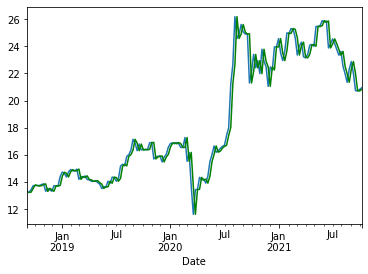

In [42]:
model = ARIMA(train,order=(5,0,2),trend='n')
arma502 = model.fit()
test_diff502 = arma502.get_forecast(steps=len(test))
test_diff502_mean = fore502.predicted_mean
test502 = invert_difference(slv_test,test_diff502_mean)
slv_test.plot()
test502.plot(color='green')
mae502 = meanabs(slv_test[1:10],test502[1:10])
rmse502 = rmse(slv_test[1:],test502)
print(f'MAE = {mae502:.3f}, RMSE = {rmse502:.3f}')

In [223]:
prediction502[tbeg:tfin]

Date
2016-02-21    14.952874
2016-02-28    14.532890
2016-03-06    13.926846
2016-03-13    14.775131
2016-03-20    14.720313
2016-03-27    14.979658
2016-04-03    14.605378
2016-04-10    14.188767
2016-04-17    14.542566
2016-04-24    15.524699
2016-05-01    16.387673
2016-05-08    16.989636
2016-05-15    16.343838
2016-05-22    15.949043
2016-05-29    15.788027
2016-06-05    15.491841
2016-06-12    15.662295
2016-06-19    16.528911
2016-06-26    16.682940
2016-07-03    16.880081
2016-07-10    18.778742
2016-07-17    19.096510
2016-07-24    18.819452
2016-07-31    18.731074
2016-08-07    19.248659
2016-08-14    18.545211
2016-08-21    18.680573
2016-08-28    18.693302
2016-09-04    17.571256
2016-09-11    18.305057
2016-09-18    18.260971
2016-09-25    17.943934
2016-10-02    18.836591
2016-10-09    17.992439
2016-10-16    16.278597
2016-10-23    16.804688
2016-10-30    16.945812
2016-11-06    16.709686
2016-11-13    17.553407
2016-11-20    16.593736
2016-11-27    15.530373
2016-12-04 

In [221]:
mae502 = meanabs(slv_train[tbeg:tfin],prediction502[tbeg:tfin])

ValueError: operands could not be broadcast together with shapes (52,) (53,) 

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ValueError: operands could not be broadcast together with shapes (52,) (53,) 

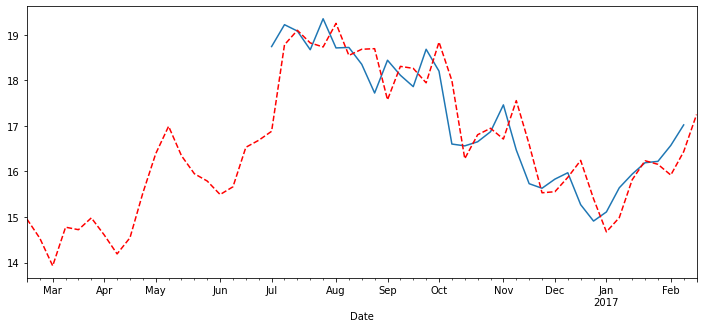

In [218]:
model = ARIMA(train,order=(5,0,2),trend='n')
arma502 = model.fit()
pred502 = arma502.get_prediction(start=-53,dynamic=False)
pred502_mean = pred502.predicted_mean
prediction502 = invert_difference(slv_train,pred502_mean)
pred502_ci = pred502.conf_int()
pred502_ll = pred502_ci.loc[:,'lower Close']
pred502_ul = pred502_ci.loc[:,'upper Close']
pred_ll = invert_difference(slv_train,pred502_ll)
pred_ul = invert_difference(slv_train,pred502_ul)
tbeg = pred502_mean.index[0].strftime('%Y-%m-%d')
tfin = pred502_mean.index[-1].strftime('%Y-%m-%d')

fig, ax = plt.subplots(1,1,figsize=(12,5))
slv_train['2014-07-01':].plot(label='training set')
prediction502.plot(color='red',linestyle='--',label='in-sample prediction')
mae502 = meanabs(slv_train[tbeg:tfin],prediction502[tbeg:tfin])
rmse502 = rmse(slv_train[tbeg:tfin],prediction502[tbeg:tfin])
ax.set_xlabel('Date')
ax.set_ylabel('SLV Price')
ax.text(datetime.date(2016,8,1),14,f'MAE = {mae502:.3f}',fontsize=20)
ax.text(datetime.date(2016,8,1),13,f'RMSE = {rmse502:.3f}',fontsize=20)
ax.fill_between(pred_ll.index, pred_ll, pred_ul, color='red',alpha=0.2,label='confidence interval')
plt.legend(loc='best')
fig.tight_layout()

In [360]:
train_slv, test_slv = weekly.Close[0:split], weekly.Close[split:]

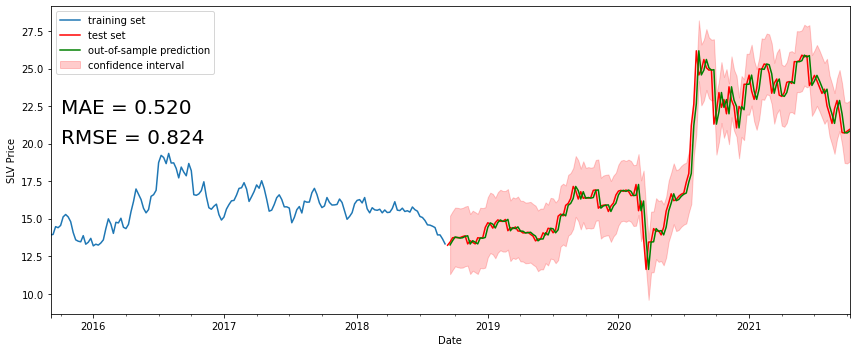

In [408]:
rtest502 = arma502.get_prediction(start=test_slv.index[0],end=test_slv.index[-1])
rtest502_mean = rtest502.predicted_mean
pred_test502 = invert_difference(test_slv,rtest502_mean)
mae_test502 = meanabs(test_slv['2018-09-23':'2021-10-10'],pred_test502['2018-09-23':'2021-10-10'])
rmse_test502 = rmse(test_slv['2018-09-23':'2021-10-10'],pred_test502['2018-09-23':'2021-10-10'])

rtest502_ci = rtest502.conf_int()
rtest502_ll = rtest502_ci.loc[:,'lower Close']
rtest502_ul = rtest502_ci.loc[:,'upper Close']
pred_ll = invert_difference(test_slv,rtest502_ll)
pred_ul = invert_difference(test_slv,rtest502_ul)


fig, ax = plt.subplots(1,1,figsize=(12,5))
xmin = datetime.date(2015,9,1)
xmax = datetime.date(2021,10,10)
ax.set_xlim(xmin,xmax)
train_slv['2015-09-01':].plot(label='training set')
test_slv.plot(color='red',label='test set')
pred_test502.plot(color='green',label='out-of-sample prediction')
ax.fill_between(pred_ll.index, pred_ll, pred_ul, color='red',alpha=0.2,label='confidence interval')
ax.set_xlabel('Date')
ax.set_ylabel('SLV Price')
ax.text(datetime.date(2015,10,1),22,f'MAE = {mae_test502:.3f}',fontsize=20)
ax.text(datetime.date(2015,10,1),20,f'RMSE = {rmse_test502:.3f}',fontsize=20)
plt.legend(loc='best')
fig.tight_layout()

In [403]:
pred_test502

2018-09-23    13.253689
2018-09-30    13.535344
2018-10-07    13.781299
2018-10-14    13.746388
2018-10-21    13.706002
                ...    
2021-09-19    21.990004
2021-09-26    20.739978
2021-10-03    20.709993
2021-10-10    20.830019
2021-10-17    20.950009
Freq: W-SUN, Length: 161, dtype: float64